In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =0

nband = 520

ng =8

ng_refs = (/ 3 , 2 , 3 /) 

nref =3

nv = 1000

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =294

vstar = 1380

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66/

data wgt
     &     /0.55 , 0.55 , 0.85 , 0.85,
     &     0.85 , 0 , 0.3 , 0.55/

atmosphere_profiles/mls75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

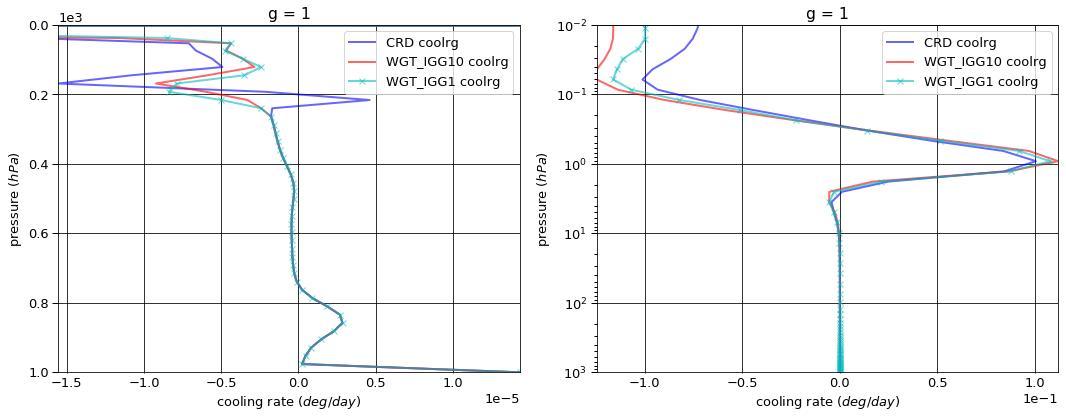

# Figure: cooling rate g-group 2

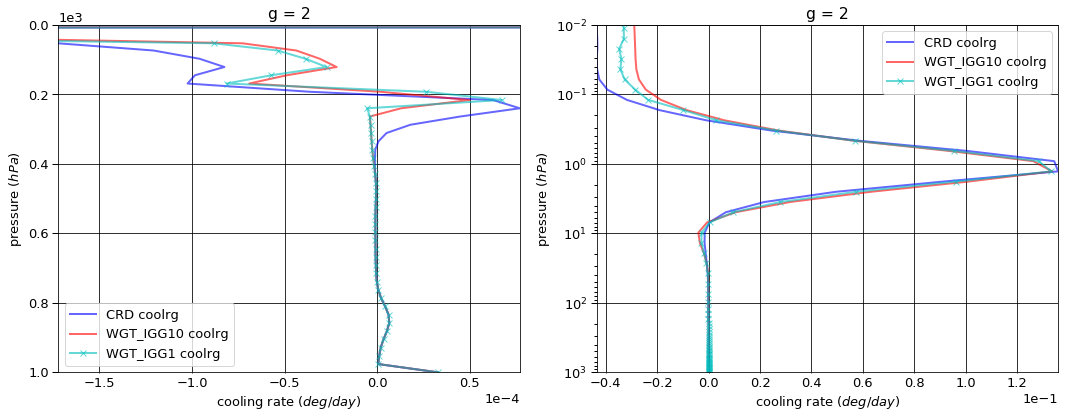

# Figure: cooling rate g-group 3

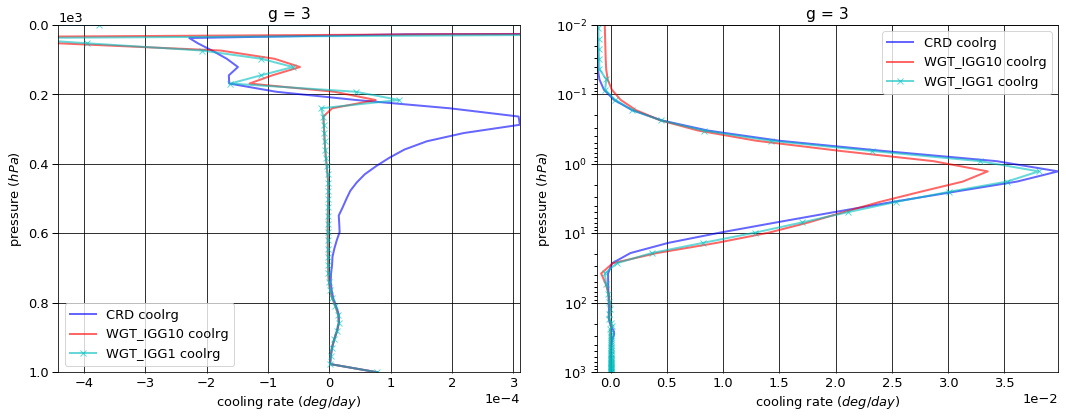

# Figure: cooling rate g-group 4

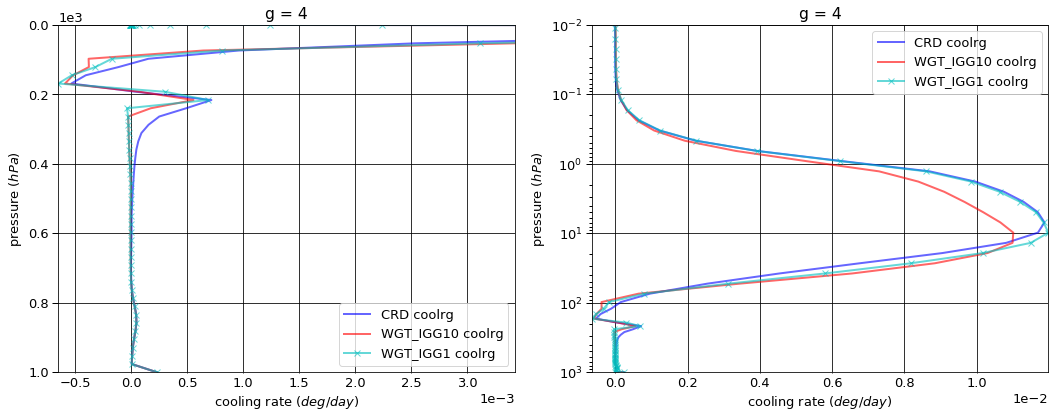

# Figure: cooling rate g-group 5

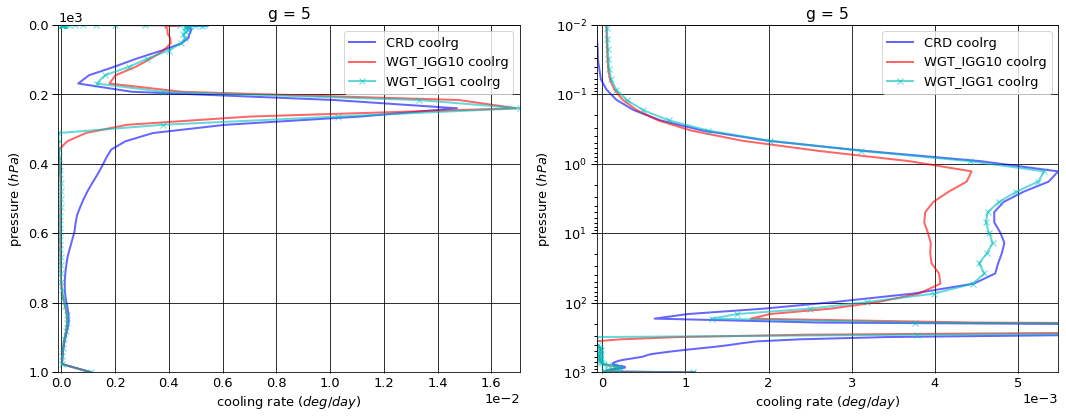

# Figure: cooling rate g-group 6

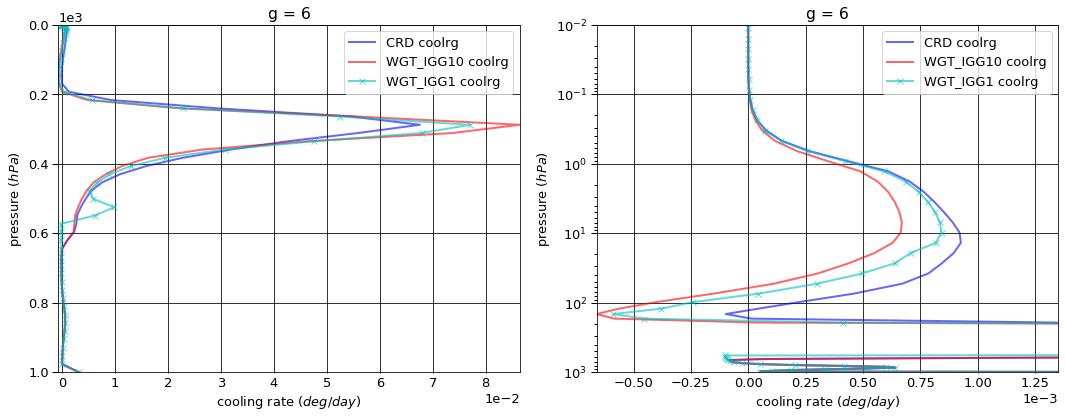

# Figure: cooling rate g-group 7

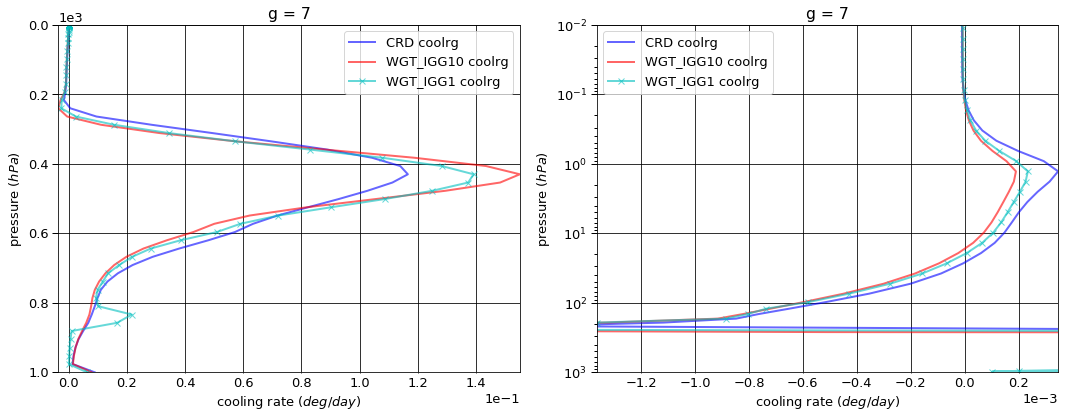

# Figure: cooling rate g-group 8

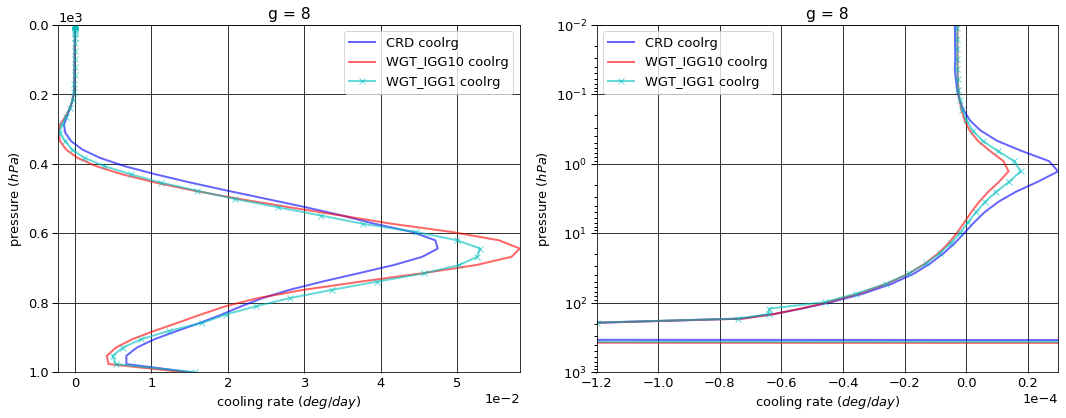

# Figure: cooling rate g-group total

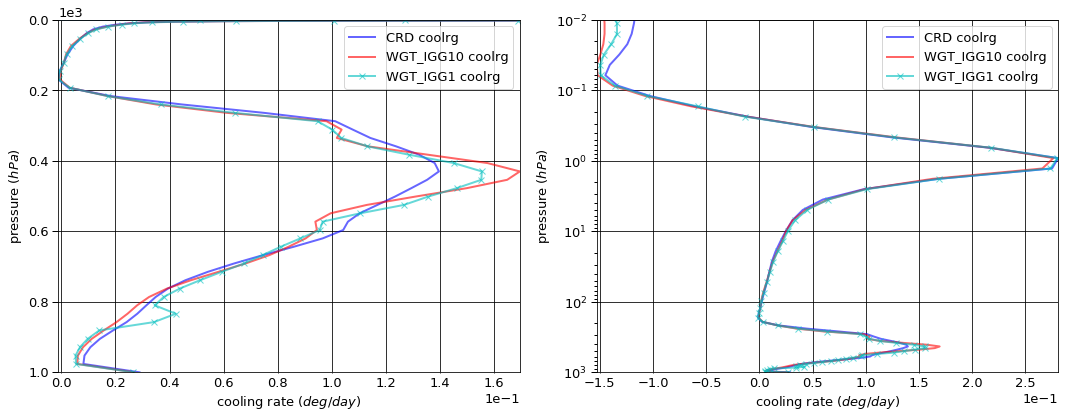

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.008894   0.000000 -0.008894
  1013.0   76     -0.034574   0.034534 -0.000040
2 0.0      1      -0.026380   0.000000 -0.026380
  1013.0   76     -0.078580   0.078489 -0.000091
3 0.0      1      -0.031929   0.000000 -0.031929
  1013.0   76     -0.188777   0.188557 -0.000220
4 0.0      1      -0.054248   0.000000 -0.054248
  1013.0   76     -0.553752   0.553108 -0.000644
5 0.0      1      -0.252519   0.000000 -0.252519
  1013.0   76     -2.622393   2.619269 -0.003124
6 0.0      1      -1.082664   0.000000 -1.082664
  1013.0   76     -7.761391   7.752354 -0.009037
7 0.0      1      -3.942289   0.000000 -3.942289
  1013.0   76    -15.339848  15.316246 -0.023603
8 0.0      1      -1.876167   0.000000 -1.876167
  1013.0   76     -4.150301   4.094225 -0.056077


WGT_IGG10


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.008401   0.000000 -0.008401
  1013.0   76     -0.034574   0.034534 -0.000040
2 0.0      1      -0.028410   0.000000 -0.028410
  1013.0   76     -0.078580   0.078489 -0.000091
3 0.0      1      -0.031914   0.000000 -0.031914
  1013.0   76     -0.188777   0.188557 -0.000220
4 0.0      1      -0.053294   0.000000 -0.053294
  1013.0   76     -0.553752   0.553108 -0.000644
5 0.0      1      -0.206979   0.000000 -0.206979
  1013.0   76     -2.622393   2.619345 -0.003047
6 0.0      1      -1.085403   0.000000 -1.085403
  1013.0   76     -7.761391   7.752354 -0.009037
7 0.0      1      -3.938831   0.000000 -3.938831
  1013.0   76    -15.339848  15.319358 -0.020490
8 0.0      1      -1.890632   0.000000 -1.890632
  1013.0   76     -4.150301   4.108939 -0.041362


WGT_IGG1


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.008585   0.000000 -0.008585
  1013.0   76     -0.034574   0.034534 -0.000040
2 0.0      1      -0.027632   0.000000 -0.027632
  1013.0   76     -0.078580   0.078489 -0.000091
3 0.0      1      -0.032344   0.000000 -0.032344
  1013.0   76     -0.188777   0.188557 -0.000220
4 0.0      1      -0.053986   0.000000 -0.053986
  1013.0   76     -0.553752   0.553108 -0.000644
5 0.0      1      -0.211435   0.000000 -0.211435
  1013.0   76     -2.622393   2.619345 -0.003047
6 0.0      1      -1.095207   0.000000 -1.095207
  1013.0   76     -7.761391   7.752354 -0.009037
7 0.0      1      -3.986117   0.000000 -3.986117
  1013.0   76    -15.339848  15.322112 -0.017737
8 0.0      1      -1.906430   0.000000 -1.906430
  1013.0   76     -4.150301   4.102365 -0.047936


WGT_IGG10 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1      4.931568e-04  0.000000e+00  4.931568e-04
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2 0.0      1     -2.029067e-03  0.000000e+00 -2.029067e-03
  1013.0   76     0.000000e+00  0.000000e+00  1.355253e-20
3 0.0      1      1.499100e-05  0.000000e+00  1.499100e-05
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
4 0.0      1      9.537010e-04  0.000000e+00  9.537010e-04
  1013.0   76     0.000000e+00  1.800000e-07  1.807800e-07
5 0.0      1      4.553992e-02  0.000000e+00  4.553992e-02
  1013.0   76     0.000000e+00  7.630000e-05  7.630660e-05
6 0.0      1     -2.739400e-03  0.000000e+00 -2.739400e-03
  1013.0   76    -8.881784e-16  0.000000e+00  0.000000e+00
7 0.0      1      3.457600e-03  0.000000e+00  3.457600e-03
  1013.0   76     0.000000e+00  3.112000e-03  3.112960e-03
8 0.0      1     -1.446520e-02  0.000000e+00 -1.446520e-02
  1013.0   76     0.000000e+00  1.471480e-02  1.471477e-02


WGT_IGG1 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1      3.087544e-04  0.000000e+00  3.087544e-04
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2 0.0      1     -1.251282e-03  0.000000e+00 -1.251282e-03
  1013.0   76     0.000000e+00  0.000000e+00  1.355253e-20
3 0.0      1     -4.146430e-04  0.000000e+00 -4.146430e-04
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
4 0.0      1      2.618050e-04  0.000000e+00  2.618050e-04
  1013.0   76     0.000000e+00  1.800000e-07  1.807800e-07
5 0.0      1      4.108469e-02  0.000000e+00  4.108469e-02
  1013.0   76     0.000000e+00  7.630000e-05  7.630660e-05
6 0.0      1     -1.254310e-02  0.000000e+00 -1.254310e-02
  1013.0   76    -8.881784e-16  0.000000e+00  0.000000e+00
7 0.0      1     -4.382860e-02  0.000000e+00 -4.382860e-02
  1013.0   76     0.000000e+00  5.866000e-03  5.866028e-03
8 0.0      1     -3.026280e-02  0.000000e+00 -3.026280e-02
  1013.0   76     0.000000e+00  8.140800e-03  8.140809e-03

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -8.536152e-02
  1001.112500 75     1.434013e-05
2 0.000312    1     -4.483841e-02
  1001.112500 75     3.256411e-05
3 0.000312    1     -1.381080e-03
  1001.112500 75     7.845469e-05
4 0.000312    1     -2.414774e-05
  1001.112500 75     2.297313e-04
5 0.000312    1     -1.073655e-04
  1001.112500 75     1.117670e-03
6 0.000312    1     -8.576582e-07
  1001.112500 75     3.222730e-03
7 0.000312    1     -1.106395e-05
  1001.112500 75     8.966185e-03
8 0.000312    1     -3.868624e-06
  1001.112500 75     1.523544e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -1.290419e-01
  1001.112500 75     1.434013e-05
2 0.000312    1     -2.997456e-02
  1001.112500 75     3.256411e-05
3 0.000312    1     -6.772769e-04
  1001.112500 75     7.841512e-05
4 0.000312    1     -1.026605e-06
  1001.112500 75     2.295722e-04
5 0.000312    1      1.771903e-05
  1001.112500 75     1.086835e-03
6 0.000312    1     -8.210093e-07
  1001.112500 75     3.222730e-03
7 0.000312    1     -8.097199e-06
  1001.112500 75     7.923189e-03
8 0.000312    1     -2.941030e-06
  1001.112500 75     1.436534e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -1.137642e-01
  1001.112500 75     1.434013e-05
2 0.000312    1     -3.446727e-02
  1001.112500 75     3.256411e-05
3 0.000312    1     -1.250843e-03
  1001.112500 75     7.841512e-05
4 0.000312    1     -9.679078e-06
  1001.112500 75     2.295722e-04
5 0.000312    1      1.852285e-05
  1001.112500 75     1.086835e-03
6 0.000312    1     -7.244458e-07
  1001.112500 75     3.222730e-03
7 0.000312    1     -8.229955e-06
  1001.112500 75     6.325952e-03
8 0.000312    1     -3.061992e-06
  1001.112500 75     1.567927e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -4.368039e-02
  1001.112500 75     0.000000e+00
2 0.000312    1      1.486385e-02
  1001.112500 75     0.000000e+00
3 0.000312    1      7.038029e-04
  1001.112500 75    -3.956600e-08
4 0.000312    1      2.312114e-05
  1001.112500 75    -1.591100e-07
5 0.000312    1      1.250845e-04
  1001.112500 75    -3.083510e-05
6 0.000312    1      3.664888e-08
  1001.112500 75     0.000000e+00
7 0.000312    1      2.966746e-06
  1001.112500 75    -1.042996e-03
8 0.000312    1      9.275937e-07
  1001.112500 75    -8.700970e-04


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.840269e-02
  1001.112500 75     0.000000e+00
2 0.000312    1      1.037114e-02
  1001.112500 75     0.000000e+00
3 0.000312    1      1.302371e-04
  1001.112500 75    -3.956600e-08
4 0.000312    1      1.446867e-05
  1001.112500 75    -1.591100e-07
5 0.000312    1      1.258883e-04
  1001.112500 75    -3.083510e-05
6 0.000312    1      1.332124e-07
  1001.112500 75     0.000000e+00
7 0.000312    1      2.833990e-06
  1001.112500 75    -2.640233e-03
8 0.000312    1      8.066326e-07
  1001.112500 75     4.438360e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.275091,0.000000,-7.275091
1013.0,76,-30.729616,30.636782,-0.092835



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.243865,0.000000,-7.243865
1013.0,76,-30.729616,30.654685,-0.074931



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.321736,0.000000,-7.321736
1013.0,76,-30.729616,30.650865,-0.078751



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.031226,0.000000,0.031226
1013.0,76,0.000000,0.017903,0.017904



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.046645,0.000000,-0.046645
1013.0,76,0.000000,0.014083,0.014083


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.131728
1001.112500,75,0.028897



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.159689
1001.112500,75,0.026953



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.149485
1001.112500,75,0.026670



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.027961
1001.112500,75,-0.001944



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.017757
1001.112500,75,-0.002227


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001075,0.001121
2,0.002500,0.002556
3,0.006004,0.006115
4,0.017237,0.017975
5,0.081883,0.085181
6,0.244898,0.251475
7,0.483221,0.502779
8,0.163183,0.132796


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,4.712719e-18
2,3.036482e-19
3,1.956454e-20
4,1.255473e-20
5,8.096279e-22
6,2.585158e-21
7,1.675857e-22
8,1.086393e-23


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,4.712719e-18,NaN,0.001075,0.001121,0.001075,0.001121,1.0
2,3.036482e-19,0.064432,0.002500,0.002556,0.003575,0.003677,1.0
3,1.956454e-20,0.064432,0.006004,0.006115,0.009579,0.009792,1.0
4,1.255473e-20,0.641708,0.017237,0.017975,0.026815,0.027768,10.0
5,8.096279e-22,0.064488,0.081883,0.085181,0.108698,0.112949,10.0
6,2.585158e-21,3.193020,0.244898,0.251475,0.353596,0.364424,500.0
7,1.675857e-22,0.064826,0.483221,0.502779,0.836817,0.867204,500.0
8,1.086393e-23,0.064826,0.163183,0.132796,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [27]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     1.661840e-17  8.673499e-18   1.915998  1.110774e-03
      2 0.000312     9.941242e-19  4.459039e-19   2.229458  6.365157e-05
      3 0.000312     2.717709e-20  1.153386e-20   2.356287  2.114603e-06
      4 0.000312     3.999111e-22  2.829685e-22   1.413271  3.256304e-08
      5 0.000312     2.646272e-22  7.137565e-23   3.707527  2.006732e-08
      6 0.000312     1.247656e-24  1.192159e-24   1.046551  1.015256e-10
      7 0.000312     2.679847e-24  1.311748e-24   2.042960  1.466626e-10
      8 0.000312     1.703651e-24  1.917044e-25   8.886864  8.714328e-11
2     1 0.000750     1.661646e-17  8.681915e-18   1.913917  4.474981e-04
      2 0.000750     9.967768e-19  4.471577e-19   2.229139  2.570740e-05
      3 0.000750     2.730143e-20  1.158221e-20   2.357187  8.556080e-07
      4 0.000750     4.033672e-22  2.860124e-22   1.410314  1.323239e-08
      5 0.000750     2.652263e-22  7.164237e-23   3.702087  8.101692e-09
      6 0.000750     1.262095e-24  1.206353e-24   1.046207  4.138004e-11
      7 0.000750     2.688170e-24  1.316455e-24   2.041976  5.927243e-11
      8 0.000750     1.706200e-24  1.922429e-25   8.875227  3.515654e-11
3     1 0.001052     1.661252e-17  8.699672e-18   1.909557  6.278449e-04
      2 0.001052     1.002362e-18  4.497615e-19   2.228652  3.625583e-05
      3 0.001052     2.754950e-20  1.166434e-20   2.361856  1.210628e-06
      4 0.001052     4.078895e-22  2.897092e-22   1.407928  1.876850e-08
      5 0.001052     2.663360e-22  7.202439e-23   3.697858  1.140983e-08
      6 0.001052     1.279391e-24  1.223150e-24   1.045980  5.883880e-11
      7 0.001052     2.704539e-24  1.325110e-24   2.040993  8.365044e-11
      8 0.001052     1.711536e-24  1.932575e-25   8.856246  4.946617e-11
4     1 0.001476     1.660815e-17  8.718350e-18   1.904965  8.812038e-04
      2 0.001476     1.008294e-18  4.525363e-19   2.228095  5.116745e-05
      3 0.001476     2.781750e-20  1.175620e-20   2.366199  1.714684e-06
      4 0.001476     4.131922e-22  2.941386e-22   1.404753  2.667919e-08
      5 0.001476     2.675548e-22  7.246079e-23   3.692408  1.608109e-08
      6 0.001476     1.300099e-24  1.243325e-24   1.045664  8.390596e-11
      7 0.001476     2.722316e-24  1.334595e-24   2.039806  1.181605e-10
      8 0.001476     1.717306e-24  1.943583e-25   8.835774  6.964333e-11
5     1 0.002070     1.660356e-17  8.736921e-18   1.900391  1.236517e-03
      2 0.002070     1.014256e-18  4.553388e-19   2.227474  7.219653e-05
      3 0.002070     2.809309e-20  1.185537e-20   2.369650  2.428574e-06
      4 0.002070     4.193172e-22  2.993996e-22   1.400527  3.798737e-08
      5 0.002070     2.688377e-22  7.294941e-23   3.685263  2.266528e-08
      6 0.002070     1.324663e-24  1.267344e-24   1.045227  1.199590e-10
      7 0.002070     2.740719e-24  1.344567e-24   2.038366  1.669137e-10
      8 0.002070     1.723225e-24  1.955012e-25   8.814394  9.803761e-11
6     1 0.002904     1.659872e-17  8.755370e-18   1.895834  1.735258e-03
      2 0.002904     1.020247e-18  4.581735e-19   2.226771  1.018797e-04
      3 0.002904     2.837795e-20  1.196408e-20   2.371928  3.440965e-06
      4 0.002904     4.265730e-22  3.057972e-22   1.394954  5.423261e-08
      5 0.002904     2.702030e-22  7.351030e-23   3.675717  3.195870e-08
      6 0.002904     1.354555e-24  1.296685e-24   1.044630  1.721666e-10
      7 0.002904     2.759898e-24  1.355173e-24   2.036565  2.358858e-10
      8 0.002904     1.729304e-24  1.966998e-25   8.791586  1.380366e-10
7     1 0.004074     1.659360e-17  8.773697e-18   1.891289  2.435185e-03
      2 0.004074     1.026276e-18  4.610499e-19   2.225955  1.437729e-04
      3 0.004074     2.867476e-20  1.208606e-20   2.372549  4.877292e-06
      4 0.004074     4.353966e-22  3.137699e-22   1.387630  7.769571e-08
      5 0.004074     2.716776e-22  7.417213e-23   3.662798  4.508274e-08
      6 0.0

# Histogram of wavenumbers in g-group 1

In [28]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [29]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
